In [1]:
!git clone https://github.com/atikul-islam-sajib/TreeBasedModel.git

Cloning into 'TreeBasedModel'...
remote: Enumerating objects: 942, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 942 (delta 20), reused 24 (delta 10), pack-reused 907
Receiving objects: 100% (942/942), 124.16 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (522/522), done.
Updating files: 100% (124/124), done.


In [2]:
%cd TreeBasedModel

/content/TreeBasedModel


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.9 MB/s eta 0:00:00


In [4]:
!pip install -e .

Obtaining file:///content/TreeBasedModel
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.2/237.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.1/777.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
  Running setup.py develop for AugmentedHierarchicalShrinkage


#### With K and Max Feature - Custom RF

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from TreeModelsFromScratch.RandomForest import RandomForest

from utils import simulate_data_strobl

def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score."""
    return roc_auc_score(y_true, y_scores)

def find_best_parameters(X_train, y_train, X_test, y_test, k_values, max_features_values):
    """Find the best k and max_features for RandomForest."""
    best_score = -1
    best_params = {'k': None, 'max_features': None}

    for k in k_values:
        for max_features in max_features_values:
            model = RandomForest(treetype="classification",
                                 HShrinkage=False,
                                 HS_smSHAP=False,
                                 n_trees=25,
                                 k=k,
                                 n_feature=max_features,
                                 random_state=42,
                                 depth_dof=False) # where depth_dof=False

            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            score = calculate_auc_roc(y_test, y_scores)

            if score > best_score:
                best_score = score
                best_params = {'k': k, 'max_features': max_features}

    return best_params, best_score

# Relevance values to explore
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]
results = []

for relevance in relevance_values:
    # Generate new data for each relevance value
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Find the best parameters for the current relevance level
    best_params, best_score = find_best_parameters(X_train, y_train, X_test, y_test, k_values, max_features_values)
    results.append({'relevance': relevance, 'best_params': best_params, 'best_score': best_score})

# Output the best parameters and their scores for each relevance level
for result in results:
    print(f"Relevance: {result['relevance']}, Best parameters: k = {result['best_params']['k']}, max_features = {result['best_params']['max_features']} with AUC-ROC score: {result['best_score']}")


Relevance: 0, Best parameters: k = 15, max_features = 0.4 with AUC-ROC score: 0.5300372142477405
Relevance: 0.05, Best parameters: k = 8, max_features = 0.2 with AUC-ROC score: 0.5257936507936508
Relevance: 0.1, Best parameters: k = 6, max_features = 0.2 with AUC-ROC score: 0.5257521672616012
Relevance: 0.15, Best parameters: k = 15, max_features = 0.6 with AUC-ROC score: 0.603717672413793
Relevance: 0.2, Best parameters: k = 15, max_features = 0.6 with AUC-ROC score: 0.7286153846153848


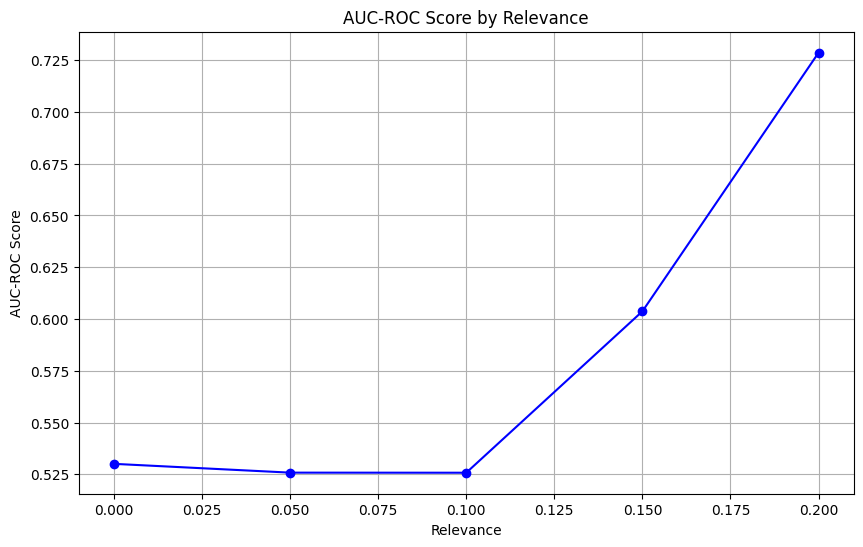

In [7]:
import matplotlib.pyplot as plt
# Prepare data for plotting
relevance_scores = [result['relevance'] for result in results]
auc_scores = [result['best_score'] for result in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(relevance_scores, auc_scores, marker='o', linestyle='-', color='b')
plt.title('AUC-ROC Score by Relevance')
plt.xlabel('Relevance')
plt.ylabel('AUC-ROC Score')
plt.grid(True)
plt.show()

### With Depth and K

In [8]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from TreeModelsFromScratch.RandomForest import RandomForest

from utils import simulate_data_strobl

def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score."""
    return roc_auc_score(y_true, y_scores)

def find_best_parameters(X_train, y_train, X_test, y_test, k_values, max_features_values):
    """Find the best k and max_features for RandomForest."""
    best_score = -1
    best_params = {'k': None, 'max_features': None}

    for k in k_values:
        for max_features in max_features_values:
            model = RandomForest(treetype="classification",
                                 HShrinkage=False,
                                 HS_smSHAP=False,
                                 n_trees=25,
                                 k=k,
                                 n_feature=max_features,
                                 random_state=42,
                                 depth_dof=True) # where depth_dof=True

            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            score = calculate_auc_roc(y_test, y_scores)

            if score > best_score:
                best_score = score
                best_params = {'k': k, 'max_features': max_features}

    return best_params, best_score

# Relevance values to explore
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = [1, 2, 4, 6, 8, 10, 15]
max_features_values = [0.2, 0.4, 0.6, 0.8]
results = []

for relevance in relevance_values:
    # Generate new data for each relevance value
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Find the best parameters for the current relevance level
    best_params, best_score = find_best_parameters(X_train, y_train, X_test, y_test, k_values, max_features_values)
    results.append({'relevance': relevance, 'best_params': best_params, 'best_score': best_score})

# Output the best parameters and their scores for each relevance level
for result in results:
    print(f"Relevance: {result['relevance']}, Best parameters: k = {result['best_params']['k']}, max_features = {result['best_params']['max_features']} with AUC-ROC score: {result['best_score']}")


Relevance: 0, Best parameters: k = 10, max_features = 0.4 with AUC-ROC score: 0.5507708665603402
Relevance: 0.05, Best parameters: k = 2, max_features = 0.8 with AUC-ROC score: 0.4841269841269842
Relevance: 0.1, Best parameters: k = 8, max_features = 0.8 with AUC-ROC score: 0.5395206527281999
Relevance: 0.15, Best parameters: k = 15, max_features = 0.6 with AUC-ROC score: 0.6306573275862069
Relevance: 0.2, Best parameters: k = 15, max_features = 0.6 with AUC-ROC score: 0.769846153846154


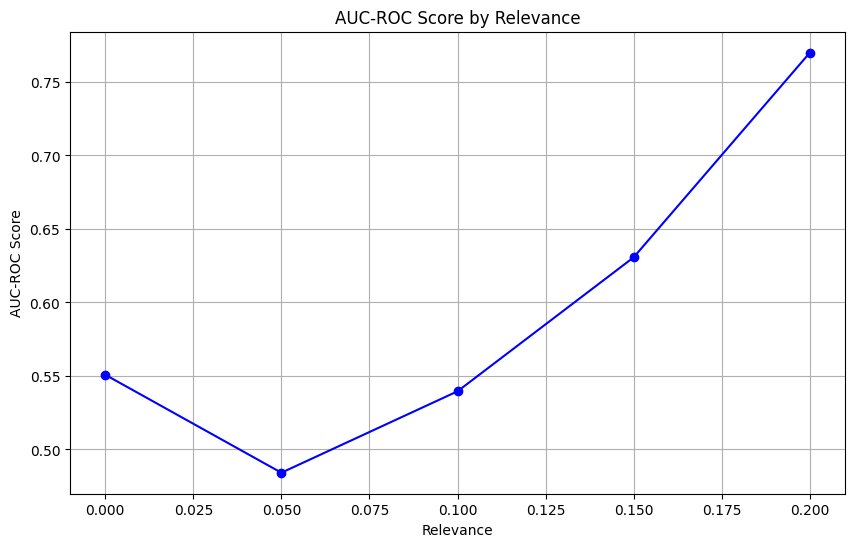

In [10]:
import matplotlib.pyplot as plt
# Prepare data for plotting
relevance_scores = [result['relevance'] for result in results]
auc_scores = [result['best_score'] for result in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(relevance_scores, auc_scores, marker='o', linestyle='-', color='b')
plt.title('AUC-ROC Score by Relevance')
plt.xlabel('Relevance')
plt.ylabel('AUC-ROC Score')
plt.grid(True)
plt.show()

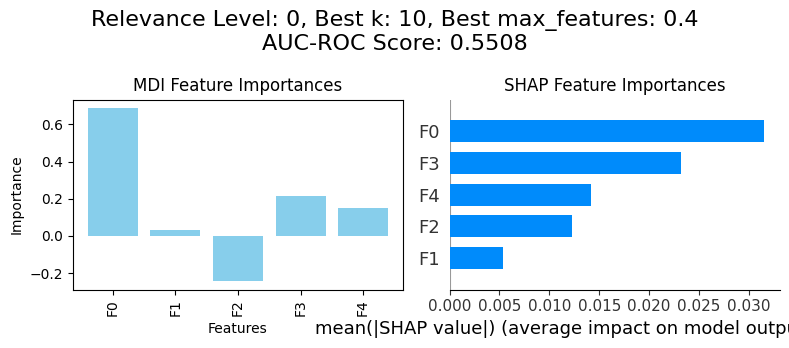

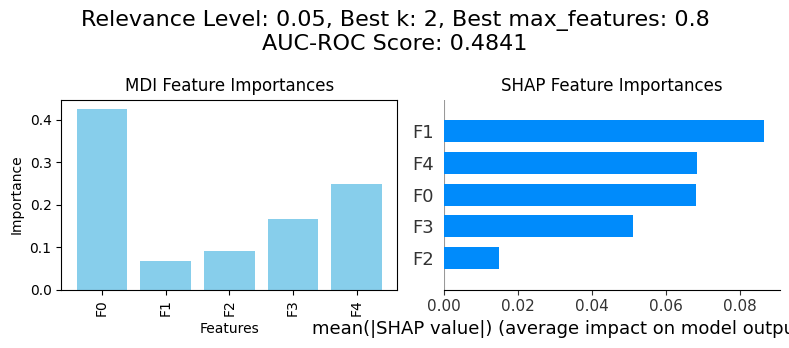

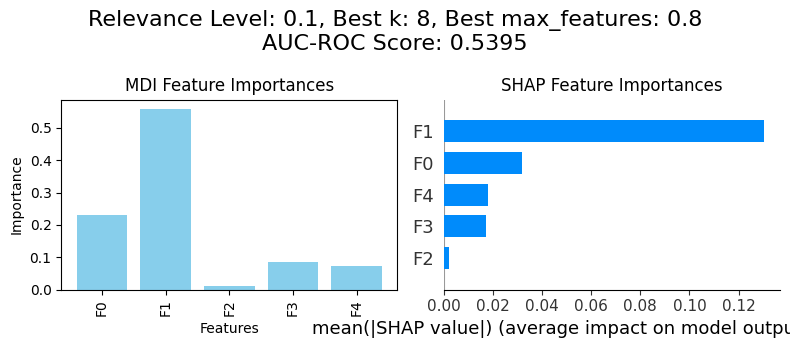

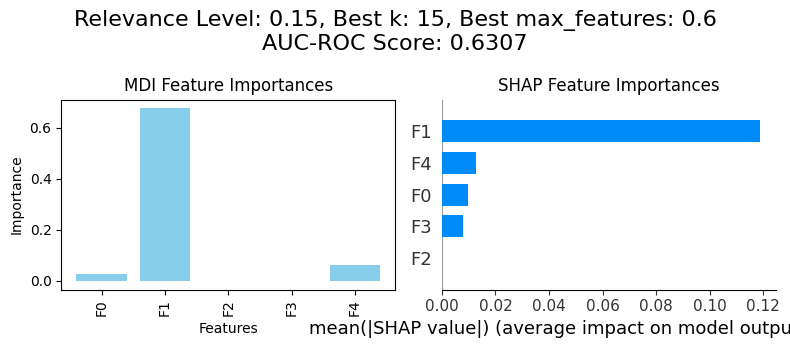

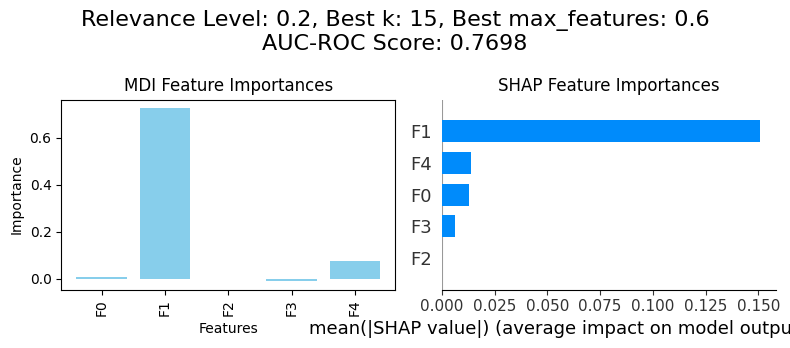

In [9]:
import matplotlib.pyplot as plt
import shap

# Loop over the results
for result in results:
    relevance = result['relevance']
    best_k = result['best_params']['k']
    best_max_features = result['best_params']['max_features']
    best_score = result['best_score']

    # Regenerate training and test sets for the current relevance level
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Instantiate and fit the RandomForest model with the best parameters found
    model = RandomForest(treetype="classification",
                         HShrinkage=False,
                         HS_smSHAP=False,
                         n_trees=25,
                         k=best_k,
                         n_feature=best_max_features,
                         random_state=42,
                         depth_dof=True) # Make depth_dof=True
    model.fit(X_train, y_train)

    # Compute and plot MDI Feature Importances
    mdi_importances = model.feature_importances_
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.subplot(1, 2, 1)
    plt.title('MDI Feature Importances')
    plt.bar(range(len(mdi_importances)), mdi_importances, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(range(X_test.shape[1]), [f'F{i}' for i in range(X_test.shape[1])], rotation='vertical')

    # Prepare model for SHAP analysis and compute SHAP values
    model_for_shap = model.export_forest_for_SHAP()
    explainer = shap.TreeExplainer(model_for_shap)
    shap_values = explainer.shap_values(X_test)

    # Plotting SHAP summary plot
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=[f'F{i}' for i in range(X_test.shape[1])], show=False)
    plt.title('SHAP Feature Importances')

    plt.suptitle(f'Relevance Level: {relevance}, Best k: {best_k}, Best max_features: {best_max_features}\nAUC-ROC Score: {best_score:.4f}', fontsize=16)

    plt.tight_layout()  # Adjust the layout
    plt.show()
